In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('input/'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('input/' + f) / 1000000, 2)) + 'MB')
        

# File sizes
clarity_train.labels          0.0MB
conciseness_train.labels      0.0MB
data_train.csv                16.0MB
data_valid.csv                5.0MB


## Training set

In [2]:
df_train = pd.read_csv("input/data_train.csv", header=None, encoding='latin-1')
df_train.columns = ["country","sku_id","title","category_lvl_1","category_lvl_2"
                    ,"category_lvl_3","short_description", "price","product_type"]
clarity_labels = pd.read_csv("input/clarity_train.labels")
conciseness_labels = pd.read_csv("input/conciseness_train.labels")
df_train['clarity'] = clarity_labels
df_train['conciseness'] = conciseness_labels
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36283 entries, 0 to 36282
Data columns (total 11 columns):
country              36283 non-null object
sku_id               36283 non-null object
title                36283 non-null object
category_lvl_1       36283 non-null object
category_lvl_2       36283 non-null object
category_lvl_3       34148 non-null object
short_description    36250 non-null object
price                36283 non-null float64
product_type         36006 non-null object
clarity              36282 non-null float64
conciseness          36282 non-null float64
dtypes: float64(3), object(8)
memory usage: 3.0+ MB


## Validation set

In [3]:
df_valid = pd.read_csv("input/data_valid.csv", header=None, encoding='latin-1')
df_valid.columns = ["country","sku_id","title","category_lvl_1","category_lvl_2"
                    ,"category_lvl_3","short_description", "price","product_type"]
df_valid['clarity'] = 'None'
df_valid['conciseness'] = 'None'
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11838 entries, 0 to 11837
Data columns (total 11 columns):
country              11838 non-null object
sku_id               11838 non-null object
title                11838 non-null object
category_lvl_1       11838 non-null object
category_lvl_2       11838 non-null object
category_lvl_3       11151 non-null object
short_description    11816 non-null object
price                11838 non-null float64
product_type         11749 non-null object
clarity              11838 non-null object
conciseness          11838 non-null object
dtypes: float64(1), object(10)
memory usage: 1017.4+ KB


In [4]:
print('Total number of description for training: {}'.format(len(df_train)))
print('Clarity: {}%'.format(round(df_train['clarity'].mean()*100, 2)))
print('Conciseness: {}%'.format(round(df_train['conciseness'].mean()*100, 2)))

Total number of description for training: 36283
Clarity: 94.34%
Conciseness: 68.53%


mean-train 75.30 std-train 30.48 mean-test 75.14 std-test 30.26 max-train 256.00 max-test 255.00


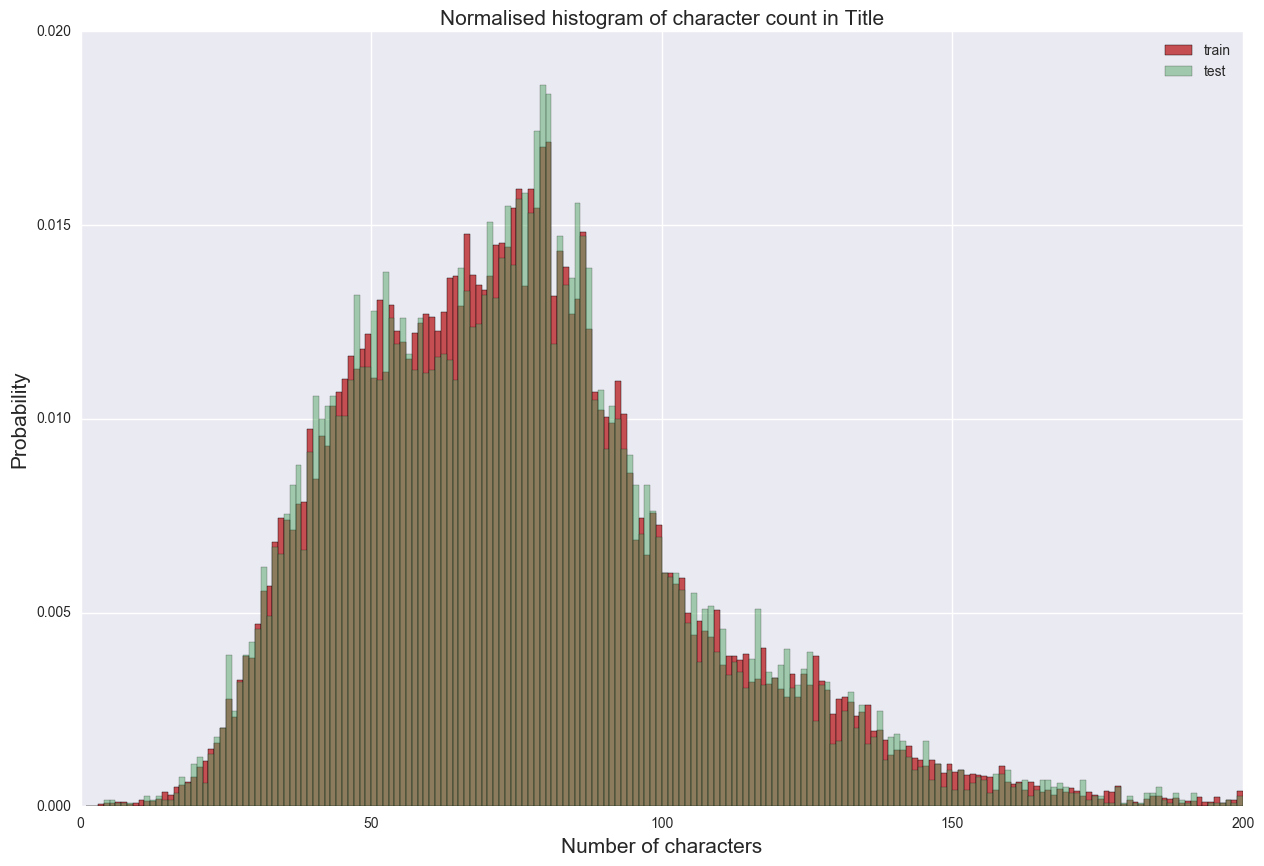

In [5]:
train_title = pd.Series(df_train['title'].tolist())
valid_title = pd.Series(df_valid['title'].tolist())

dist_train_title = train_title.apply(len)
dist_valid_title = valid_title.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train_title, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_valid_title, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in Title', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train_title.mean(), 
                          dist_train_title.std(), dist_valid_title.mean(), dist_valid_title.std(), dist_train_title.max(), dist_valid_title.max()))

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### Preprocess Data

In [6]:
df_total = pd.concat([df_train, df_valid])

In [7]:
# df_train['product_type'] = df_train['product_type'].fillna("None")
# df_valid['product_type'] = df_valid['product_type'].fillna("None")
# df_train['product_type'].unique()
df_total['product_type'] = df_total['product_type'].fillna("None")

In [8]:
# df_train['category_lvl_3'] = df_train['category_lvl_3'].fillna("None")
# df_valid['category_lvl_3'] = df_valid['category_lvl_3'].fillna("None")

# df_train['short_description'] = df_train['short_description'].fillna("None")
# df_valid['short_description'] = df_valid['short_description'].fillna("None")
df_total['category_lvl_3'] = df_total['category_lvl_3'].fillna("None")
df_total['short_description'] = df_total['short_description'].fillna("None")

In [9]:
df_total = df_total.dropna()

### Short description

In [10]:
import re

# Clean HTML Tags
def clean_html(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [11]:
df_total['short_description'] = df_total['short_description'].apply(lambda x: clean_html(x))

### Extract Nouns and Adjustive for Title and Description

In [12]:
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords

In [13]:
stop = stopwords.words('english')
def cleaning_text(sentence):
   sentence = sentence.lower()
   sentence = re.sub('[^\w\s]',' ', sentence) #removes punctuations
   sentence = re.sub('\d+',' ', sentence) #removes digits
   cleaned = ' '.join([w for w in sentence.split() if not w in stop]) # removes english stopwords
   cleaned = ' '.join([w for w , pos in pos_tag(cleaned.split()) if (pos == 'NN' or pos=='JJ' or pos=='JJR' or pos=='JJS' )])
   #selecting only nouns and adjectives
   cleaned = ' '.join([w for w in cleaned.split() if not len(w)<=2 ]) #removes single lettered words and digits
   cleaned = cleaned.strip()
   return cleaned

In [14]:
df_total['cleaned_title'] = df_total['title'].apply(lambda x: cleaning_text(x))
df_total['cleaned_desc'] = df_total['short_description'].apply(lambda x: cleaning_text(x))

In [15]:
df_total['num_title_words'] = df_total['cleaned_title'].apply(lambda x: len(x.split(" ")))
df_total['num_description_words'] = df_total['cleaned_desc'].apply(lambda x: len(x.split(" ")))

#### Make category bag of words

In [17]:
df_total['category_lvl_1'].unique()

array([u'Fashion', u'Health & Beauty',
       u'TV, Audio / Video, Gaming & Wearables', u'Computers & Laptops',
       u'Cameras', u'Home & Living', u'Watches Sunglasses Jewellery',
       u'Mobiles & Tablets', u'Home Appliances'], dtype=object)

In [31]:
fashion_title = ', '.join(df_total[df_total['category_lvl_1'].str.contains("Fashion") == True]['title'])

In [32]:
fashion_title

u'Adana Gallery Suri Square Hijab \xe2\x80\x93 Light Pink, Hanyu Men PU Leather Lace Up Cap-Toe Business Casual Shoes Black, Prado2u LYY Korean Canvas Crossbody Bag FLISH 19 Grey, 2016 New Arrive Women Four Seasons Flats Casual Shoes Women Flat Heel Cow Muscle Outsole Fashion Flat Women Genuine Leather Shoes, Toprank Women Sexy Strapless Sleeveless Solid Bodycon Mini Dress Party Club Wear ( Khaki ), RUDY Dress, Women Canvas Navy Style ID Credit Card Bag Girls Coin Bags Purse (Orange), Men\'s Leather Bifold Multi Pocket Credit ID Cards Long Wallet (Brown), Blusas Femininas 2015 Fashion Tropical Women Blouses Sexy Lace Shirt Sleeveless Worsted Design Solid Pattern Female Party Blouse S-2XL Black, 2017 New Men\'s Stand-up Collar Jacket Green, Gel Orthotic Arch Support Massaging Shoe Insole Run Pad (12.2\xe2\x80\x98\xe2\x80\x99 Blue), Yingwei High Quality Ladies PU Leather Wallet Portable Purse Rose Red, ZANZEA Summer Boho Women Casual Loose Sleeveless Long Dress Vintage Pockets Irregular 

### Categorical data

In [ ]:
from sklearn import preprocessing
features_to_use = ["price"]
categorical = ["country", "category_lvl_1", "category_lvl_2", "category_lvl_3", "product_type"]
for f in categorical:
        if df_total[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df_total[f].values))
#             df_train[f] = lbl.transform(list(df_train[f].values))
#             df_valid[f] = lbl.transform(list(df_valid[f].values))
            df_total[f] = lbl.transform(list(df_total[f].values))
            features_to_use.append(f)

### XGBoost

In [ ]:
features_to_use.extend(["num_description_words", "num_title_words"])

In [ ]:
from sklearn.cross_validation import train_test_split

# Conciseness
x_train, x_valid, y_train, y_valid = train_test_split(df_train[features_to_use], df_train['conciseness'], test_size=0.2, random_state=4242)

# Clarity
# x_train, x_valid, y_train, y_valid = train_test_split(df_train[features_to_use], df_train['conciseness'], test_size=0.2, random_state=4242)

In [ ]:
import xgboost as xgb

def run_xgb(x_train, y_train, x_valid, y_valid):
    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'rmse'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)
    
    return bst

In [ ]:
bst = run_xgb(x_train, y_train, x_valid, y_valid)

## Validation Submission

In [ ]:
d_test = xgb.DMatrix(df_valid[features_to_use])
p_test = bst.predict(d_test)

sub = pd.DataFrame(p_test)
sub.to_csv('output/20170524/clarity_valid.predict', index=False)

In [ ]:
d_test = xgb.DMatrix(df_valid[features_to_use])
p_test = bst.predict(d_test)

sub = pd.DataFrame(p_test)
sub.to_csv('output/20170524/conciseness_valid.predict', index=False)

### Submit using mean

In [ ]:
from sklearn.metrics import log_loss

p_clarity = df_train['clarity'].mean()
p_conciseness = df_train['conciseness'].mean()

# print('Predicted clarity score:', log_loss(df_train['clarity'], np.zeros_like(df_train['clarity']) + p_clarity))
# print('Predicted conciseness score:', log_loss(df_train['conciseness'], np.zeros_like(df_train['conciseness']) + p_conciseness))

df_valid = pd.read_csv("input/data_valid.csv", header=None)
df_valid.columns = ["country","sku_id","title","category_lvl_1","category_lvl_2"
                    ,"category_lvl_3","short_description", "price","product_type"]
df_valid['p_clarity'] = p_clarity
df_valid['p_conciseness'] = p_conciseness
df_valid['p_clarity'].to_csv("output/20170522/clarity_valid.predict", index=False)
df_valid['p_conciseness'].to_csv("output/20170522/conciseness_valid.predict", index=False)

In [ ]:
df_train['category_lvl_3'].unique()